In [2]:
!pip install torch
!pip install torchvision
!pip install kaggle
!pip install matplotlib
!pip install spacy
!pip install pandas

# English tokenizer data
!spacy download en_core_web_sm

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... error
  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [43 lines of output]
      Traceback (most recent call last):
        File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 353, in <module>
          main()
        File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 335, in main
          json_out['return_val'] = hook(**hook_input['kwargs'])
                                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "/usr/local/lib/python3.11/dist-packages/pip/_vendor/pyproject_hooks/_in_process/_in_process.py", line 152, in prepare_metadata_for_build_wheel
          whl_basename = backend.build_wheel(metadata_directory, config_settings)
                         ^

In [3]:
# Used for model
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

# Used to format data
import torchvision
import torchvision.transforms as transforms
# Used to show results
import matplotlib.pyplot as plt

# Used to download data
import os
#import kaggle
import zipfile
from pathlib import Path

# Additional file imports
from model2 import EncoderDecoder
from image_captioning_from_scratch import CNNtoRNN
from dataset import Flickr8kDataset
from dataset import Collate

# Used to convert test images
from PIL import Image

In [4]:
# Displays an image with its respective caption
def displayImage(img, caption):
    
    # Unnormalize Image
    img[0] = img[0] * 0.229
    img[1] = img[1] * 0.224 
    img[2] = img[2] * 0.225 
    img[0] += 0.485 
    img[1] += 0.456 
    img[2] += 0.406
    # Show image
    plt.figure()
    plt.imshow(img.permute(1,2,0))
    plt.title(caption)
    plt.axis("off")

In [25]:
# Data transformations
transform = transforms.Compose(
    [
        transforms.Resize((512,512)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Load dataset
dataset_path = "./dataset/"
root = os.path.join(dataset_path, 'Images')
annotations = os.path.join(dataset_path, 'captions.txt')
freq_threshold = 3
dataset = Flickr8kDataset(root, annotations, transform, freq_threshold)

# Get device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Parameters
embed_size = 300
decoder_dim = 512
attention_dim = 256
vocab_size = 4091
p = 0.5
# Load trained model
checkpoint =  torch.load("./models/NewModel6.pth", map_location=device)
model = EncoderDecoder(embed_size, decoder_dim, attention_dim, vocab_size, p).to(device)
model.load_state_dict(checkpoint['state_dict'])

# Test image transforms
test_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)



In [6]:
# Get numerical index of padding
pad_idx = dataset.vocab.stoi["<PAD>"]
dataloader = DataLoader(
    dataset,
    batch_size = 8,
    num_workers = 2,
    shuffle = True,
    collate_fn=Collate(pad_idx)
    )

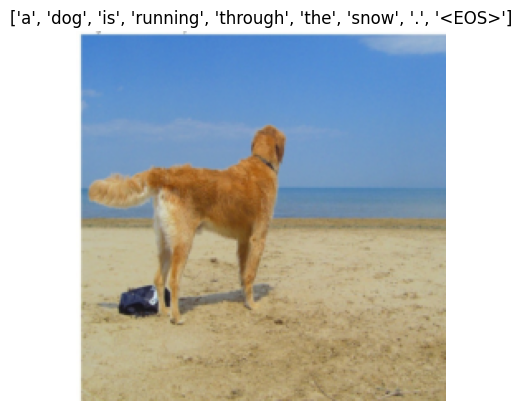

In [26]:
# Turn evaluation mode on
model.eval()

# Test Image 1
test_image1 = test_transform(Image.open("test_examples/dog.jpg").convert("RGB")).unsqueeze(0)

# Predictions
feature = model.encoder(test_image1.to(device))
caption = model.decoder.generate_caption(feature, vocab = dataset.vocab)

displayImage(test_image1.squeeze(0), caption)

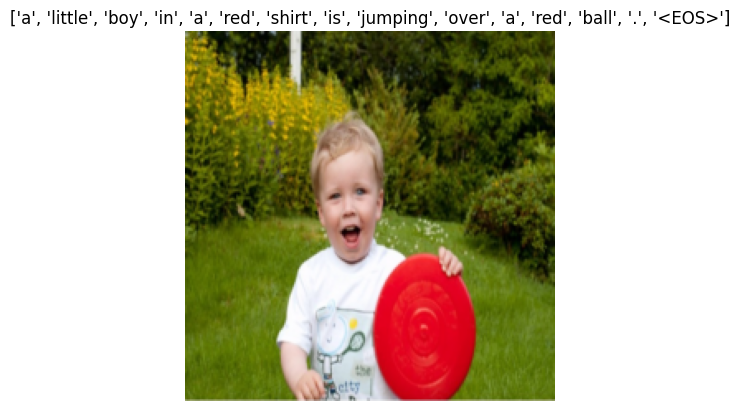

In [27]:
# Test Images 2
test_image2 = test_transform(Image.open("test_examples/child.jpg").convert("RGB")).unsqueeze(0)

feature = model.encoder(test_image2.to(device))
caption = model.decoder.generate_caption(feature, vocab = dataset.vocab)

displayImage(test_image2.squeeze(0), caption)

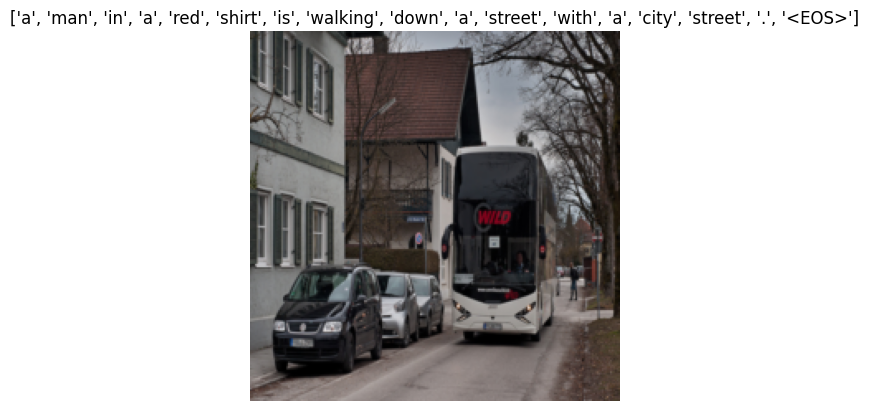

In [28]:
# Test Image 3
test_image3 = test_transform(Image.open("test_examples/bus.png").convert("RGB")).unsqueeze(0)

caption = model.caption_image(test_image3.to(device), dataset.vocab)

displayImage(test_image3.squeeze(0), caption)

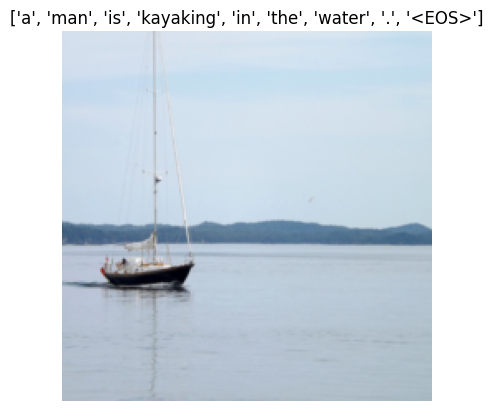

In [29]:
# Test Image 4
test_image4 = test_transform(Image.open("test_examples/boat.png").convert("RGB")).unsqueeze(0)

caption = model.caption_image(test_image4.to(device), dataset.vocab)

displayImage(test_image4.squeeze(0), caption)

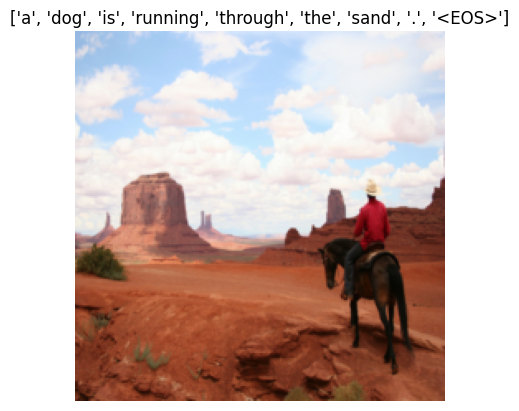

In [30]:
# Test Image 5
test_image5 = test_transform(Image.open("test_examples/horse.png").convert("RGB")).unsqueeze(0)

caption = model.caption_image(test_image5.to(device), dataset.vocab)

displayImage(test_image5.squeeze(0), caption)

In [8]:
j = 1
model.eval()
with torch.inference_mode():
    
    for i, (images, captions) in enumerate(dataloader):
        break
        # Get batch of images and captions
        images, captions = images.to(device), captions.to(device)

        # Make predictions 
        preds = model(images, captions.permute(1,0))
        
        preds = torch.argmax(preds, 2)
        
        # Creates caption of image 'j'
        pred_caption = []
        for i in range(preds.shape[0]):
            pred_caption.append(dataset.vocab.itos[preds[i,j].item()])
        # Display image with predicted caption
        displayImage(images[j].cpu(),pred_caption)
        break

In [7]:
dataset.vocab.stoi['brown']

42

In [19]:
dataset.vocab.itos[1823]

'sideways'

In [10]:
a = torch.rand(4,4)
a

tensor([[0.8054, 0.9299, 0.6396, 0.7705],
        [0.2617, 0.7499, 0.8860, 0.1297],
        [0.4763, 0.1747, 0.9245, 0.5052],
        [0.3100, 0.4576, 0.0422, 0.3642]])

In [11]:
a[1,1] = 0

In [13]:
captions.permute(1,0)[:,1:]

tensor([[   4,  100,  115,    4,    3,   48,   18,  452,    2,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [ 472,   87,   50,  290, 2401,   13,    3,  123,    4,   96, 1654,  665,
            2,    0,    0,    0,    0,    0,    0,    0,    0],
        [   4,   22,  104,  672, 1097,  101,  557,   51,    4,   22,   46,    4,
           19,   25,  209,   29,    9,  166,    5,    2,    0],
        [   9,  221,  629,    8,    9, 1557,   98,   18,  635,    9,   37, 2988,
           65,    9, 1259,   15,    9,   11,  812,    5,    2],
        [   4,  311,    7,  220,    8,    9,   61,   31,   64,  425,  387,  165,
            5,    2,    0,    0,    0,    0,    0,    0,    0],
        [   4,    7,    3,   29,    9,  525,   13,    4, 1085,    5,    2,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0],
        [   4,   40,   46,   42,  524,    8,    4,  351,  418,    4,   74,  433,
            5,    2,    0,    0,    0,    0,    0